如今，我们已经了解了 PyTorch 中张量及其运算，但这远远不够。本次实验将学会如何使用 PyTorch 方便地构建神经网络模型，以及 PyTorch 训练神经网络的步骤及方法。

知识点
PyTorch 构建神经网络
Sequential 容器结构
使用 GPU 加速训练
模型保存与推理

方便定义不同类型的 Tensor 及利于反向传播的 Autograd 机制是深度学习框架的重要特点，但真正带来极大便利的，莫过于已经封装好的不同神经网络结构组件，包括不同类型的层以及各式各样的损失函数、激活函数、优化器等。

PyTorch 搭建神经网络结构的组件在 torch.nn 中 ，这些神经网络层大多以类出现，例如全连接层：torch.nn.Linear() ，MSE 损失函数类：torch.nn.MSELoss()  等。

除此之外，torch.nn.functional  下面同样也有神经网络层，激活函数，损失函数等，但均以函数出现，例如全连接层函数：torch.nn.functional.linear() ，MSE 损失函数：torch.nn.functionalmse_loss()  等。

总之，torch.nn 下面包含了神经网络组件类（大写字母），而 torch.nn.functional 包含了神经网络组件函数（小写字母）。

本次实验使用的数据集为 MNIST，你可以把它看成是 DIGITS 数据集的增强版，都是手写字符任务。前面我们使用过 Fashion MNIST 数据集，MNIST 数据集和其样本特征是一致的，只是样本类别不一样。MNIST 中每个样本是 
28
×
28
28×28 的矩阵，目标是字符 0-9。

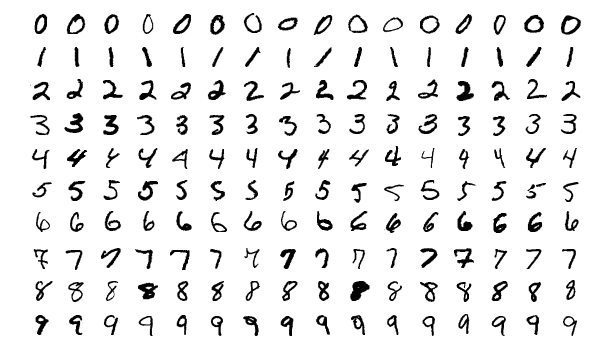

我们可以直接使用 PyTorch 提供的计算机视觉增强模块 torchvision 加载 MNIST 数据集。由于数据集托管在外网服务器上，国内的下载速度较慢，实验从蓝桥云课服务器下载该数据集。

In [1]:
# 从蓝桥云课服务器下载数据集
!wget -nc "http://labfile.oss.aliyuncs.com/courses/1081/MNIST.zip"
!unzip -o "MNIST.zip"

--2025-02-04 18:21:11--  http://labfile.oss.aliyuncs.com/courses/1081/MNIST.zip
正在解析主机 labfile.oss.aliyuncs.com (labfile.oss.aliyuncs.com)... 47.110.177.159
正在连接 labfile.oss.aliyuncs.com (labfile.oss.aliyuncs.com)|47.110.177.159|:80... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 11511167 (11M) [application/zip]
正在保存至: “MNIST.zip”

MNIST.zip           100%[===================>]  10.98M  --.-KB/s    用时 0.1s    

2025-02-04 18:21:12 (88.6 MB/s) - 已保存 “MNIST.zip” [11511167/11511167])

Archive:  MNIST.zip
   creating: MNIST/
   creating: MNIST/processed/
  inflating: MNIST/processed/training.pt  
  inflating: MNIST/processed/test.pt  


In [2]:
import torchvision

# 加载训练数据，参数 train=True，供 60000 条
train = torchvision.datasets.MNIST(
    root='.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
# 加载测试数据，参数 train=False，供 10000 条
test = torchvision.datasets.MNIST(
    root='.', train=False, transform=torchvision.transforms.ToTensor(), download=True)

上面的代码中，transform=torchvision.transforms.ToTensor()  是利用了 torchvision 提供的 transforms 直接将原 NumPy 数组转换为 PyTorch 张量。现在，你可以尝试输出训练和测试数据的特征和目标查看。

In [3]:
train.data.shape, train.targets.shape, test.data.shape, test.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

接下来，我们还需要使用 PyTorch 提供的一个组件对数据进行封装。torch.utils.data.DataLoader  是 PyTorch 提供的及其常用的数据加载器，它可以将数据集封装成迭代器以方便我们后续进行小批量加载，数据打乱等操作。数据加载器准备好之后，后续只需要通过 for 循环来使用即可。

In [4]:
import torch

# 训练数据打乱，使用 64 小批量
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=64, shuffle=True)
# 测试数据无需打乱，使用 64 小批量
test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=64, shuffle=False)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f936ea723d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f936ea72460>)

接下来，我们学习 PyTorch 构建神经网络的经典方法，也是官方推荐使用的一种方法。

首先，torch.nn 中的一个基础类 torch.nn.Module 。该类是 PyTorch 中所有神经网络的基类，它既可以表示神经网络中的某层，也可以表示若干层的神经网络。torch.nn 中的各个类实际上就是由 torch.nn.Modules 继承而拓展。所以，在实际使用中，我们可以继承nn.Module，撰写自定义网络层。

所以，当我们搭建神经网络时，也需要继承 torch.nn.Module。我们准备搭建一个包含两个隐含层的全连接网络。

输入（784） → 全连接层 1 （784, 512）→ 全连接层 2 （512, 128）→ 输出（10）

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)  # 784 是因为训练是我们会把 28*28 展平
        self.fc2 = nn.Linear(512, 128)  # 使用 nn 类初始化线性层（全连接层）
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 直接使用 relu 函数，也可以自己初始化一个 nn 下面的 Relu 类使用
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 输出层一般不激活
        return x

我们定义了新的神经网络结构类 Net()，并使用 nn.Linear 组合了 3 个线性层（全连接层）。前向传播过程中，代码使用了 PyTorch 中常用的函数模块 torch.nn.functional 提供的 RELU 激活函数，实际上你也可以通过实例化 nn.Relu 来达到同样的效果。

下面，我们实例化自定义神经网络类：

In [7]:
model = Net()
model

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

PyTorch 的好处在于你可以初始化一个 784 长度的随机值样本传入网络，测试一下输出：

In [8]:
model(torch.randn(1, 784))

tensor([[ 0.0246, -0.0786,  0.0767, -0.0982,  0.0471,  0.0742, -0.0060, -0.0947,
          0.0489,  0.0698]], grad_fn=<AddmmBackward0>)

目前，我们已经搭好了前向传播网络。下面的步骤和 TensorFlow 非常相似：定义损失函数，优化器以及开始训练。

In [9]:
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数
opt = torch.optim.Adam(model.parameters(), lr=0.002)  # Adam 优化器

这里，我们选择了十分常用的交叉熵损失函数 nn.CrossEntropyLoss ，以及 Adam 优化器 torch.optim.Adam 。值得注意的是，PyTorch 中优化器需传入模型的参数 model.parameters()，这是 PyTorch 的一个使用特性。

接下来，我们就可以开始训练了，这部分代码非常重要。

In [10]:
def fit(epochs, model, opt):
    print("Start training, please be patient.")
    # 全数据集迭代 epochs 次
    for epoch in range(epochs):
        # 从数据加载器中读取 Batch 数据开始训练
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28)  # 对特征数据展平，变成 784
            labels = labels  # 真实标签
            outputs = model(images)  # 前向传播
            loss = loss_fn(outputs, labels)  # 传入模型输出和真实标签
            opt.zero_grad()  # 优化器梯度清零，否则会累计
            loss.backward()  # 从最后 loss 开始反向传播
            opt.step()  # 优化器迭代
            # 自定义训练输出样式
            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Batch [{}/{}], Train loss: {:.3f}'
                      .format(epoch+1, epochs, i+1, len(train_loader), loss.item()))
        # 每个 Epoch 执行一次测试
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model(images)
            # 得到输出最大值 _ 及其索引 predicted
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()  # 如果预测结果和真实值相等则计数 +1
            total += labels.size(0)  # 总测试样本数据计数
        print('============ Test accuracy: {:.3f} ============='.format(
            correct / total))

In [11]:
fit(epochs=1, model=model, opt=opt)  # 训练 1 个 Epoch，预计持续 10 分钟

Start training, please be patient.
Epoch [1/1], Batch [100/938], Train loss: 0.278
Epoch [1/1], Batch [200/938], Train loss: 0.203
Epoch [1/1], Batch [300/938], Train loss: 0.148
Epoch [1/1], Batch [400/938], Train loss: 0.127
Epoch [1/1], Batch [500/938], Train loss: 0.306
Epoch [1/1], Batch [600/938], Train loss: 0.088
Epoch [1/1], Batch [700/938], Train loss: 0.102
Epoch [1/1], Batch [800/938], Train loss: 0.092
Epoch [1/1], Batch [900/938], Train loss: 0.151
============ Test accuracy: 0.964 =============


上方的代码中有详细的注释，但依旧有几点值得注意的地方。

首先，由于 PyTorch 没有提供类似于 Flatten 这样的展平类，所以我们通过 reshape 操作将输入 
28
×
28
28×28 展平为 784，使其和网络结构参数符合。你也可以使用 view，但官方更推荐使用 reshape 。

其次，opt.zero_grad() 这步非常关键。由于 PyTorch 设计时梯度会累计，所以我们需要手动清零以实现传入一个 Batch，计算梯度，然后更新参数，从而不会因为前面的梯度累计影响后面的参数更新。但 PyTorch 这样设计也是有原因的，比如当我们想提升 Batch 的大小而硬件又无法处理较多数据时，就可以通过梯度累积机制，等待传入多个 Batch 后再更新参数并执行清零，这就给了开发更多的灵活性。同时，后续循环神经网络中也可能利用到这个特性。

# Sequential 容器结构

上面，我们学习了使用 PyTorch 构建神经网络模型的经典方法步骤。你会发现 PyTorch 使用起来比 TensorFlow 要简单一些，主要体现在 DataLoader 数据加载器和前向传播过程调试较为方便，以及无需管理会话等。但是，PyTorch 又似乎比 Keras 要复杂一些，尤其是需要手动构建训练过程，还需要注意执行 opt.zero_grad() 等额外步骤。

实际上，由于 PyTorch 未提供像 tf.keras 这种更高阶的 API，所以无法达到与 Keras 相似的便捷程度。不过，我们可以使用 PyTorch 提供的 Sequential 网络结构来优化上面的经典过程，使得神经网络结构定义的部分更精简一些。

上面，我们通过继承 nn.Module 来定义了网络结构 Net() 类。实际上，利用 nn.Sequential  可以让这个过程更加直观简便。你可以直接按顺序将网络需要的组件类添加到 Sequential 容器结构中。

In [12]:
model_s = nn.Sequential(
    nn.Linear(784, 512),  # 线性类
    nn.ReLU(),  # 激活函数类
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

In [13]:
model_s  # 查看网络结构

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)

接下来，我们直接利用上面定义好的损失函数和训练函数完成模型优化迭代过程。由于优化器中需要传入模型的参数，所以这里需要修改为后续定义的 Sequential 模型。接下来，我们直接利用上面定义好的损失函数和训练函数完成模型优化迭代过程。由于优化器中需要传入模型的参数，所以这里需要修改为后续定义的 Sequential 模型。

In [14]:
opt_s = torch.optim.Adam(model_s.parameters(), lr=0.002)  # Adam 优化器
fit(epochs=1, model=model_s, opt=opt_s)  # 训练 1 个 Epoch

Start training, please be patient.
Epoch [1/1], Batch [100/938], Train loss: 0.234
Epoch [1/1], Batch [200/938], Train loss: 0.209
Epoch [1/1], Batch [300/938], Train loss: 0.355
Epoch [1/1], Batch [400/938], Train loss: 0.136
Epoch [1/1], Batch [500/938], Train loss: 0.074
Epoch [1/1], Batch [600/938], Train loss: 0.046
Epoch [1/1], Batch [700/938], Train loss: 0.114
Epoch [1/1], Batch [800/938], Train loss: 0.064
Epoch [1/1], Batch [900/938], Train loss: 0.096
============ Test accuracy: 0.963 =============


# 使用GPU加速训练

图形处理器 GPU 是深度学习加速训练的重要硬件。当我们使用 TensorFlow 构建神经网络时，一般会自动调用 GPU 而无需修改代码 。不过，PyTorch 使用 GPU 加速会麻烦一些，我们需要将数据张量和模型都转化为 CUDA 类型 。为了方便大家在使用 PyTorch 时调用 GPU，下面给出一般流程用于参考。

首先，我们需要验证 PyTorch 是否可以使用当前 GPU 用于加速计算。torch.cuda.is_available()  如果返回 True 即代表 GPU 可用，False 则代表只能使用 CPU。

In [15]:
torch.cuda.is_available()

False

由于当前使用只配备了 CPU 环境，所以上面返回 False，不过不影响本小节内容学习。

一般，我们会提前写好一个判断语句，以保证代码能够在 CPU 或者 GPU 环境中均能正常执行。

In [16]:
# 如果 GPU 可用则使用 CUDA 加速，否则使用 CPU 设备计算
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cpu')

然后修改代码，数据和模型后面添加 .to(dev)，这样 PyTorch 就可以自动判断是否使用 GPU 加速了。首先是对从 DataLoader 中加载出来的每一批次数据后添加 .to(dev)。我们沿用 fit(epochs, model, opt) 中的代码。

In [17]:
def fit(epochs, model, opt):
    print("Start training, please be patient.")
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28).to(dev)  # 添加 .to(dev)
            labels = labels.to(dev)  # 添加 .to(dev)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            opt.zero_grad()
            loss.backward()
            opt.step()
            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Batch [{}/{}], Train loss: {:.3f}'
                      .format(epoch+1, epochs, i+1, len(train_loader), loss.item()))
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(dev)  # 添加 .to(dev)
            labels = labels.to(dev)  # 添加 .to(dev)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print('============ Test accuracy: {:.3f} ============='.format(
            correct / total))

接下来，给模型添加 .to(dev)，使得模型可以自动判断是否使用 CUDA 加速。请注意，由于优化器中传入了模型的参数，而该参数可能会因为 GPU 变更为 CUDA 类型，所以我们需要重新执行优化器代码防止数据类型不一致而报错。

In [18]:
model_s.to(dev)
opt_s = torch.optim.Adam(model_s.parameters(), lr=0.002)

最终完成训练即可，如果有 GPU 则速度会明显优于 CPU。

In [19]:
fit(epochs=1, model=model_s, opt=opt_s)  # 训练 1 个 Epoch

Start training, please be patient.
Epoch [1/1], Batch [100/938], Train loss: 0.114
Epoch [1/1], Batch [200/938], Train loss: 0.229
Epoch [1/1], Batch [300/938], Train loss: 0.067
Epoch [1/1], Batch [400/938], Train loss: 0.187
Epoch [1/1], Batch [500/938], Train loss: 0.089
Epoch [1/1], Batch [600/938], Train loss: 0.062
Epoch [1/1], Batch [700/938], Train loss: 0.077
Epoch [1/1], Batch [800/938], Train loss: 0.097
Epoch [1/1], Batch [900/938], Train loss: 0.217
============ Test accuracy: 0.976 =============


# 模型的保存与推理

我们同样可以保存 PyTorch 模型以用于推理。直接使用 torch.save  将模型存在 .pt 文件即可。

In [20]:
torch.save(model_s, './model_s.pt')

接下来，使用 torch.load  加载模型即可使用模型进行推理。

In [21]:
model_s = torch.load('./model_s.pt')
model_s

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)

我们使用测试数据中的第一个样本作为示例进行推理。

In [22]:
# 对测试数据第一个样本进行推理，注意将张量类型转换为 FloatTensor
result = model_s(test.data[0].reshape(-1, 28*28).type(torch.FloatTensor).to(dev))
torch.argmax(result)  # 找到输出最大值索引即为预测标签

tensor(7)

打印第一个测试样本的真实标签。

In [23]:
test.targets[0]  # 第一个测试数据真实标签

tensor(7)

实际上，关于 PyTorch 模型的保存还有其他方法和适用情况，例如 CPU 训练的模型放置到 GPU 环境中进行推理等。更多内容，希望大家后续抽时间详细学习官方文档相应章节内容 。

本次实验中，我们学习了如何继承 PyTorch 中神经网络基类 torch.nn.Module 搭建网络结构，并通过 MNIST 演示了 PyTorch 用于模型训练的完整过程。这是使用 PyTorch 构建人工神经网络最常用的方法，大家一定要牢牢掌握。当然，实验最后，我们还了解了如何使用 nn.Sequential 构建模型容器，以及 PyTorch 模型保存与 GPU 加速计算等内容。后续，推荐大家结合 PyTorch 官方文档示例来深入了解并掌握该框架的运用。

https://pytorch.org/docs/stable/index.html
官方api
https://pytorch.org/docs/stable/index.html
入门教程